In [1]:
import os
import time
import lightgbm as lgb
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import tensorflow as tf

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## 直方图

In [2]:
datapath = "/home/jovyan/histogram"

# with open("black_list.pkl", "rb") as f:
#     black_list = pickle.load(f)
# with open("white_list.pkl", "rb") as f:
#     white_list = pickle.load(f)

# black_path = [os.path.join(datapath, sp) for sp in black_list]
# white_path = [os.path.join(datapath, sp) for sp in white_list]

with open("/home/datacon/malware/XXX/black.txt", 'r') as f:
    black_list = f.read().strip().split()

with open("/home/datacon/malware/XXX/white.txt", 'r') as f:
    white_list = f.read().strip().split()

with open("models/hash_list.pkl", 'rb') as f:
    hash_list = pickle.load(f)

black_path, white_path = [], []
for ha in hash_list:
    if ha in black_list:
        black_path.append(os.path.join(datapath, ha))
    else:
        white_path.append(os.path.join(datapath, ha))

In [3]:
raw_feature, raw_labels = [], []

with tqdm(total=11647, ncols=80, desc="histogram") as pbar:
    for fp in black_path:
        with open(fp+'.txt', 'r') as f:
            feature = f.readlines()
        feature = [float(his.strip()) for his in feature]
        raw_feature.append(feature)
        raw_labels.append(1)
        pbar.update(1)
    for fp in white_path:
        with open(fp+'.txt', 'r') as f:
            feature = f.readlines()
        feature = [float(his.strip()) for his in feature]
        raw_feature.append(feature)
        raw_labels.append(0)
        pbar.update(1)

histogram: 100%|████████████████████████| 11647/11647 [00:03<00:00, 3849.49it/s]


In [4]:
features, labels = np.array(raw_feature, dtype=np.float32), np.array(raw_labels, dtype=np.int32)

In [5]:
model = tf.keras.models.load_model('models/histogram_0.97.h5')

In [6]:
histogram_train = model.predict(features)

In [7]:
sum([1 for i in histogram_train if i >= 0.5])

3758

## PE静态特征

In [8]:
with open("oof/raw_feature_stacking_train_5.pkl", "rb") as fp:
    raw_feature_stacking_train_5 = pickle.load(fp)

In [9]:
labels = []
for ha in hash_list:
    if ha in black_list:
        labels.append(1)
    else:
        labels.append(0)

In [10]:
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13,
            "family": "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label, y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    score = tpr[1] - 0.9*fpr[0]
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{0}, auc={1:.2f}, score={2:.2f}".format(model, auc*100, score*100), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(raw_feature_stacking_train_5, 
                                                                    labels, 
                                                                    test_size=0.2, 
                                                                    random_state=1)

# model = XGBClassifier(n_estimators=300, learning_rate=0.04, max_depth=4, reg_lambda=0.4, seed=4396, scale_pos_weight=3)
# model.fit(train_data, train_labels)
# y_pred = model.predict(test_data)
rfc_pe_model = RandomForestClassifier(100, random_state=8)
rfc_pe_model.fit(train_data, train_labels)
train_pred = rfc_pe_model.predict(train_data)
y_pred = rfc_pe_model.predict(test_data)

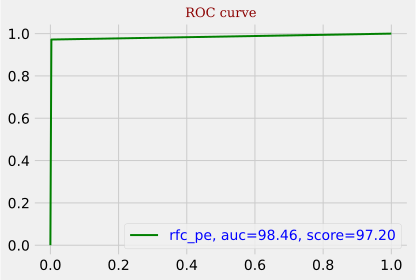

In [12]:
plot(train_labels, train_pred, "rfc_pe")

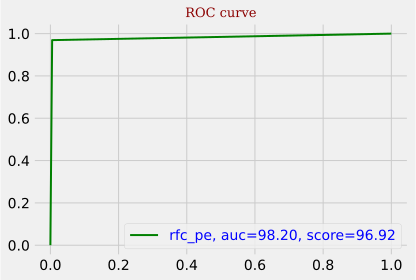

In [13]:
plot(test_labels, y_pred, "rfc_pe")

In [14]:
raw_feature_train = rfc_pe_model.predict(raw_feature_stacking_train_5).reshape(-1, 1)

In [15]:
with open("models/rfc_pe_model.pkl", "wb") as f:
    pickle.dump(rfc_pe_model, f)
# with open("models/xgb_pe_model.pkl", "wb") as f:
#     pickle.dump(rfc_pe_model, f)

## 特征工程

In [16]:
# with open("/home/jovyan/feature_engineering/feature_engineering_features.pkl", 'rb') as f:
#     feature_engineering_features = pickle.load(f)
    
# with open("/home/jovyan/feature_engineering/keys.pkl", 'rb') as f:
#     keys = pickle.load(f)

# with open("/home/jovyan/models/lgb_models.pkl", "rb") as fp:
#     lgb_models = pickle.load(fp)

# train_df = pd.DataFrame(feature_engineering_features, columns=keys)

# n_splits = 5

# oof_test_skf = np.empty((n_splits, 11647))

# for i, model in enumerate(lgb_models):
#     oof_test_skf[i, :] = model.predict(train_df, num_iteration=model.best_iteration)

# feature_engineerin_train = oof_test_skf.mean(axis=0).reshape(-1, 1)


In [16]:
with open("oof/feature_engineerin_train.pkl", "rb") as fp:
    feature_engineerin_train = pickle.load(fp)

## 融合

In [17]:
train = np.hstack([feature_engineerin_train, histogram_train , raw_feature_train])

In [18]:
stacking_train_5 = train

train_data, test_data, train_labels, test_labels = train_test_split(stacking_train_5,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=2020) # 0x4651

In [19]:
lr_model = LogisticRegression(random_state=7)
lr_model.fit(train_data, train_labels)
train_pre_lr = lr_model.predict(train_data)
y_pred_lr = lr_model.predict(test_data)

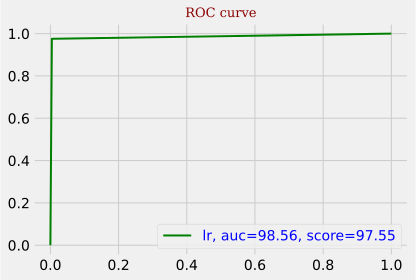

In [20]:
plot(train_labels, train_pre_lr, "lr")

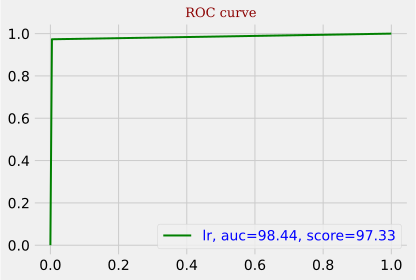

In [21]:
plot(test_labels, y_pred_lr, "lr")

In [22]:
params = {'num_leaves': 8, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 1,
          'objective': 'binary', #定义的目标函数
          'max_depth': 3,
          'learning_rate': 0.01,
          "min_sum_hessian_in_leaf": 8,
          "boosting": "gbdt",
          "feature_fraction": 0.9,	#提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,				#l1正则
          # 'lambda_l2': 0.001,		#l2正则
          "verbosity": -1,
          "nthread": -1,				#线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss'},	##评价函数选择
          "random_state": 5555,	#随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
}
trn_data = lgb.Dataset(train_data, label=train_labels)
val_data = lgb.Dataset(test_data, label=test_labels)
clf = lgb.train(params, trn_data, 1000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds=20)
train_pred_lgb = clf.predict(train_data)
train_pred_lgb_b = np.where(train_pred_lgb < 0.5, 0, 1)

y_pred_lgb = clf.predict(test_data)
y_pred_lgb_b = np.where(y_pred_lgb < 0.5, 0, 1)

Training until validation scores don't improve for 20 rounds
[200]	training's binary_logloss: 0.0921109	valid_1's binary_logloss: 0.0947185
[400]	training's binary_logloss: 0.0440921	valid_1's binary_logloss: 0.0487651
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.0387491	valid_1's binary_logloss: 0.044802


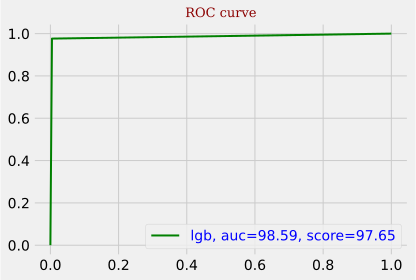

In [23]:
plot(train_labels, train_pred_lgb_b, "lgb")

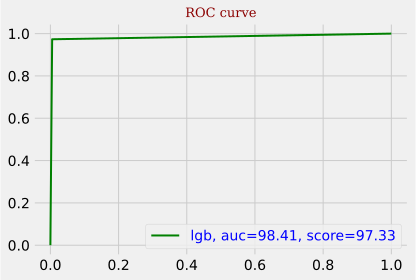

In [24]:
plot(test_labels, y_pred_lgb_b, "lgb")

In [25]:
rfc_model = RandomForestClassifier(100, random_state=7)
rfc_model.fit(train_data, train_labels)
train_pred_rfc = rfc_model.predict(train_data)
y_pred_rfc = rfc_model.predict(test_data)

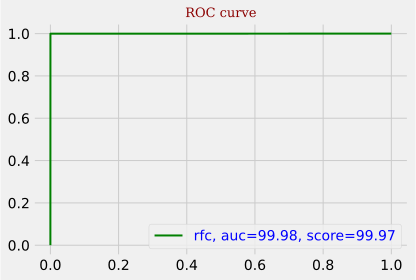

In [26]:
plot(train_labels, train_pred_rfc, "rfc")

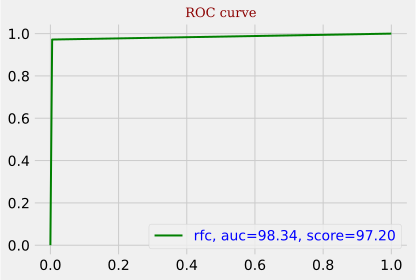

In [27]:
plot(test_labels, y_pred_rfc, "rfc")

In [35]:
labels_lr = lr_model.predict_proba(train)
labels_rfc = rfc_model.predict_proba(train)


labels_lgb = clf.predict(stacking_train_5)
train_labels = []
for x, y in zip(labels_lr, labels_rfc):
    if x[1]*0.3 + y[1]*0.7 < 0.5:
        train_labels.append(0)
    else:
        train_labels.append(1)

In [36]:
sum(train_labels)

3827

In [37]:
accs = accuracy_score(labels, train_labels)
fpr, tpr, _ = metrics.roc_curve(labels, train_labels)
auc = metrics.roc_auc_score(labels, train_labels)
score = tpr[1] - 1.2*fpr[0]

In [38]:
accs, auc, score

(0.9922726882459002, 0.9893859620622801, 0.9807049138152817)

In [39]:
with open("models/lr_rfc.pkl", "wb") as f:
    pickle.dump([lr_model, rfc_model], f)